In [1]:
import torch
import matplotlib.pyplot as plt
from torcheval.metrics.functional import r2_score
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Distances import Distances
from Coordinates import Coordinates
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
mean_dist_fp = '../data/mean_dists.pt'
mean_sq_dist_fp = '../data/squares.pt'
raw_fp = '../data/samples/origami_64_no_embed_reduction/eval_mode/unguided.pt'
cor_fp = '../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt'

In [3]:
save_folder = './raw_vs_corrected/'

In [4]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

Load the data, prepare as necessary

In [5]:
raw_dists = Distances(torch.load(raw_fp)).unfold().unnormalize(mean_dist_fp=mean_dist_fp,mean_sq_dist_fp=mean_sq_dist_fp)

In [6]:
coords = Coordinates(cor_fp)

Convert to nm

In [7]:
coords._values*= 100
raw_dists._values*= 100

Ignore conformations with non-finite values in the raw distance maps

In [8]:
idx = torch.where((~raw_dists.values.isfinite()).any(-1).any(-1))[0]
invalid_dists = raw_dists[idx]
invalid_coords = coords[idx]

idx = torch.where(raw_dists.values.isfinite().all(-1).all(-1))[0]
raw_dists = raw_dists[idx]
coords = coords[idx]

Drop redundant information

In [9]:
n = coords.num_beads
i,j = torch.triu_indices(n,n,1)
invalid_dists = invalid_dists.values[:,i,j]
invalid_coords = invalid_coords.distances.values[:,i,j]
raw_dist_vals = raw_dists.values[:,i,j]
cor_dist_vals = coords.distances.values[:,i,j]

Get and sort the r-squared values

In [10]:
with torch.inference_mode():
    # For all samples that didn't contain non-finite values in the raw diffusion output
    r2_scores = r2_score(cor_dist_vals.T,raw_dist_vals.T,multioutput='raw_values')
sorted_r2,sorted_r2_indices = r2_scores.sort(descending=True)

Also benchmark the invalid conformations by computing the average R-squared value among finite distances in those conformations

In [11]:
# Deal with the NaN values
r2_scores_2 = []
for i in range(invalid_coords.shape[0]):
    idx1 = torch.where(invalid_dists[i,:].isfinite())[0]
    r2_scores_2.append(r2_score( invalid_coords[i:i+1,idx1].T, invalid_dists[i:i+1,idx1].T ))
r2_scores_2 = torch.tensor(r2_scores_2)

Print the average R-squared values

In [12]:
print(f'Fully-defined R-squared values: {r2_scores.mean()}')
print(f'Average among maps with infinite distances: {r2_scores_2.mean()}')
print(f'Combined average: {torch.cat([r2_scores,r2_scores_2]).mean()}')

Fully-defined R-squared values: 0.9913924336433411
Average among maps with infinite distances: 0.9886523485183716
Combined average: 0.9913515448570251


#### Plot the distance maps

WORST matches

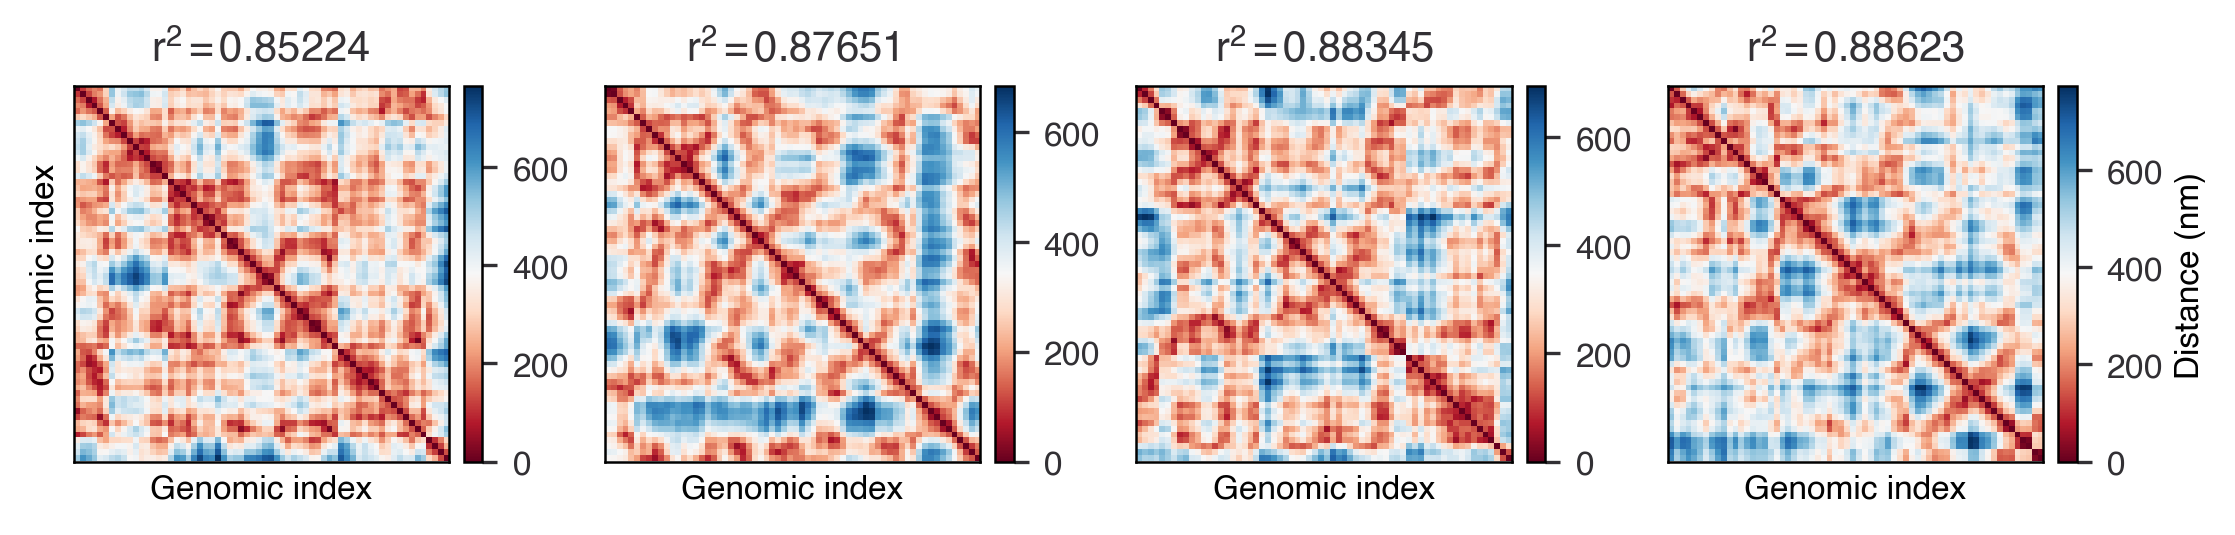

In [13]:
fig,axes = plt.subplots(ncols=4,nrows=1,figsize=(7.08661,1.67),layout='constrained')
for k,i in enumerate(range(-1,-5,-1)):
    *_,cbar = raw_dists[sorted_r2_indices[i]].plot_with(coords[sorted_r2_indices[i]].distances,fig=fig,ax=axes[k])
    
    axes[k].set_ylabel('Genomic index' if k == 0 else '')
    axes[k].set_xlabel('Genomic index')
    if k == 3:
        cbar.set_label('Distance (nm)')
    else:
        cbar.set_label('')
        #cbar.remove()
    axes[k].set_title('$\\mathdefault{r^2 ='+f'{round(float(sorted_r2[i]),5)}'+'}$')
fig.savefig(save_folder+'worst_matches.pdf')

Best matches

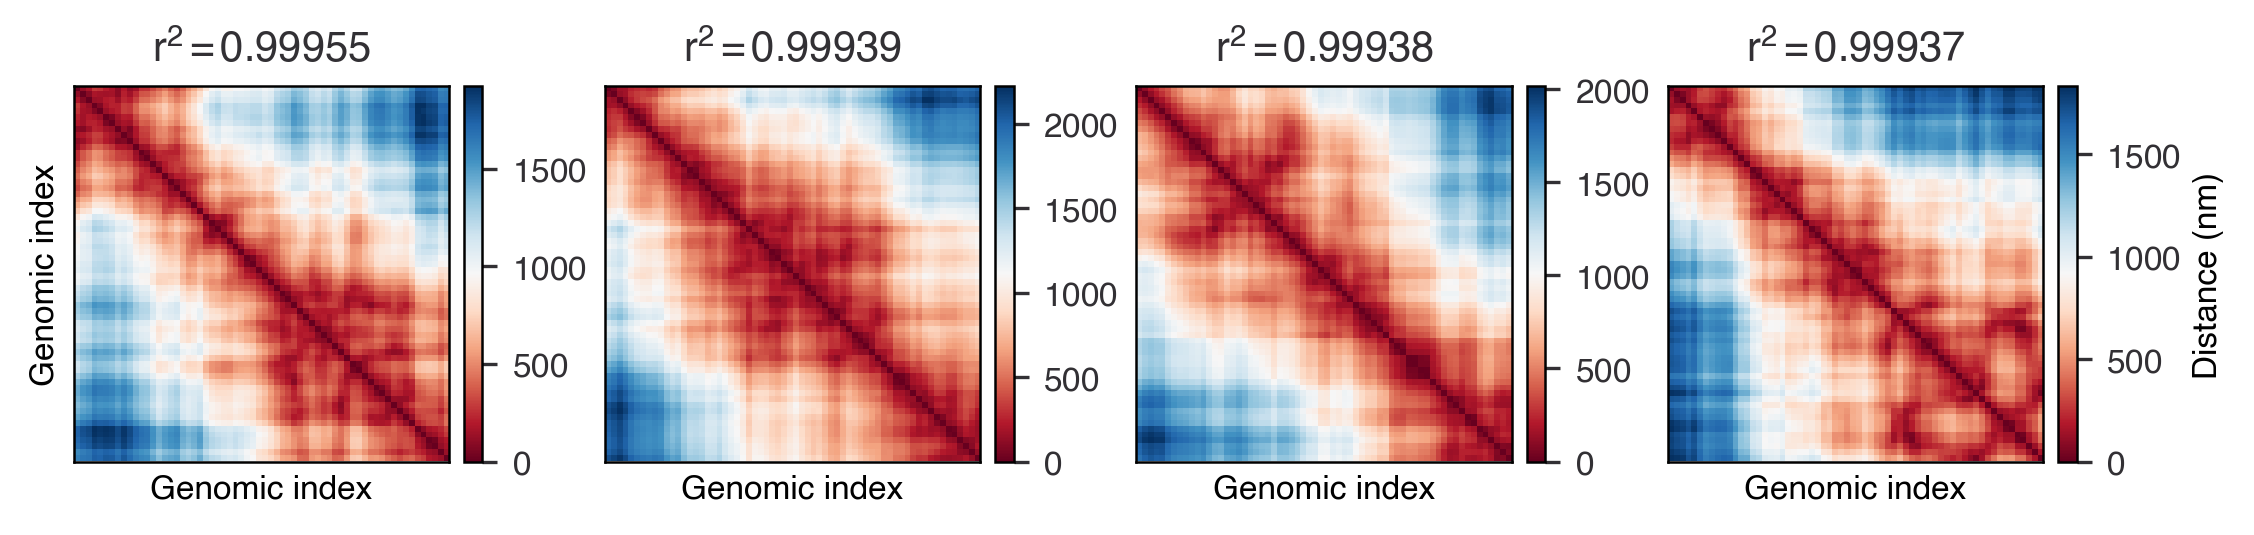

In [14]:
fig,axes = plt.subplots(ncols=4,nrows=1,figsize=(7.08661,1.67),layout='constrained')
for k,i in enumerate(range(4)):
    *_,cbar = raw_dists[sorted_r2_indices[i]].plot_with(coords[sorted_r2_indices[i]].distances,fig=fig,ax=axes[k])
    
    axes[k].set_ylabel('Genomic index' if k == 0 else '')
    axes[k].set_xlabel('Genomic index')
    if k == 3:
        cbar.set_label('Distance (nm)')
    else:
        cbar.set_label('')
        #cbar.remove()
    axes[k].set_title('$\\mathdefault{r^2 ='+f'{round(float(sorted_r2[i]),5)}'+'}$')
fig.savefig(save_folder+'best_matches.pdf')

Quintiles

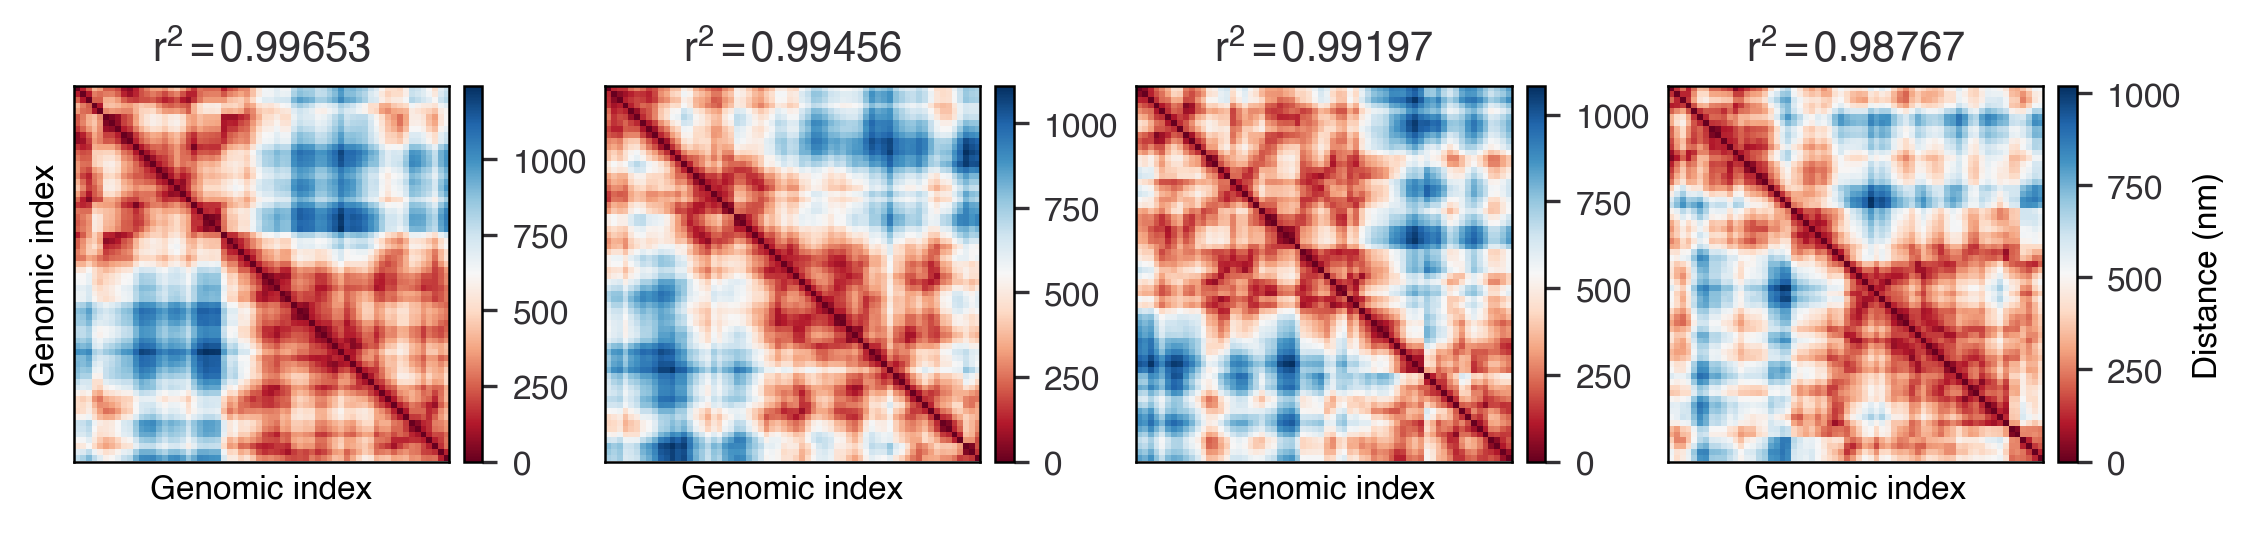

In [15]:
fig,axes = plt.subplots(ncols=4,nrows=1,figsize=(7.08661,1.67),layout='constrained')
N_quintile = len(coords)//5
quintile_idxs = [N_quintile*i for i in range(1,5)]
for k,i in enumerate(quintile_idxs):
    *_,cbar = raw_dists[sorted_r2_indices[i]].plot_with(coords[sorted_r2_indices[i]].distances,fig=fig,ax=axes[k])
    
    axes[k].set_ylabel('Genomic index' if k == 0 else '')
    axes[k].set_xlabel('Genomic index')
    if k == 3:
        cbar.set_label('Distance (nm)')
    else:
        cbar.set_label('')
        #cbar.remove()
    axes[k].set_title('$\\mathdefault{r^2 ='+f'{round(float(sorted_r2[i]),5)}'+'}$')
fig.savefig(save_folder+'quintiles.pdf')

#### Show the distances on a 2D plot + $r^2$ histogram

In [16]:
def compare_dists_scatter(idxs,r2s,corrected=coords,uncorrected=raw_dists,fig=None,ax=None,norm=True):

    # Scatter Plot
    
    if type(idxs) != list:
        idxs = [idxs]

    n = uncorrected.num_beads
    i,j = torch.triu_indices(n,n,1)

    mins = []
    maxes= []
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    for k,idx in enumerate(idxs):
    
        corr = corrected[idx].distances.values[0,i,j]
        uncorr = uncorrected.values[idx,i,j]
        if norm:
            maxx = max(corr.max(),uncorr.max())
            corr/= maxx
            uncorr/= maxx
        mins.append(max(corr.min(),uncorr.min()))
        maxes.append(min(corr.max(),uncorr.max()))

        ax.plot(uncorr,corr,'.',label='$\\mathdefault{'+f'{round(float(r2s[k]),5)}'+'}$')
        #if len(idxs) == 1:
        #    ax.plot(uncorr,corr,'.',label='Data')
        #elif k == 0:
        #    ax.plot(uncorr,corr,'.',alpha=.5,label='By mean absolute deviation')
        #else:
        #    ax.plot(uncorr,corr,'.',alpha=.5,label='By mean square deviation')

    #min_max = [min(mins),max(maxes)]
    #ax.plot(min_max,min_max,label='Perfect Match')
    #lims = [0,max(ax.get_ylim()[-1],ax.get_xlim()[-1])]
    #ax.set_xlim(lims)
    #ax.set_ylim(lims)
    #ax.set_aspect(1.0, adjustable='box')

    xrange = uncorr.max()
    ax.set_xlim([-.045*xrange,1.125*xrange])
    yrange = corr.max()
    ax.set_ylim([-.045*yrange,1.125*yrange])

    if norm:
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    ax.legend(loc='upper left',bbox_to_anchor=(-.075*xrange,1.01*yrange),framealpha=0,handletextpad=-.5,fontsize='small')
    ax.set_xlabel('Uncorrected distances')
    ax.set_ylabel('Corrected distances')

    return fig, ax

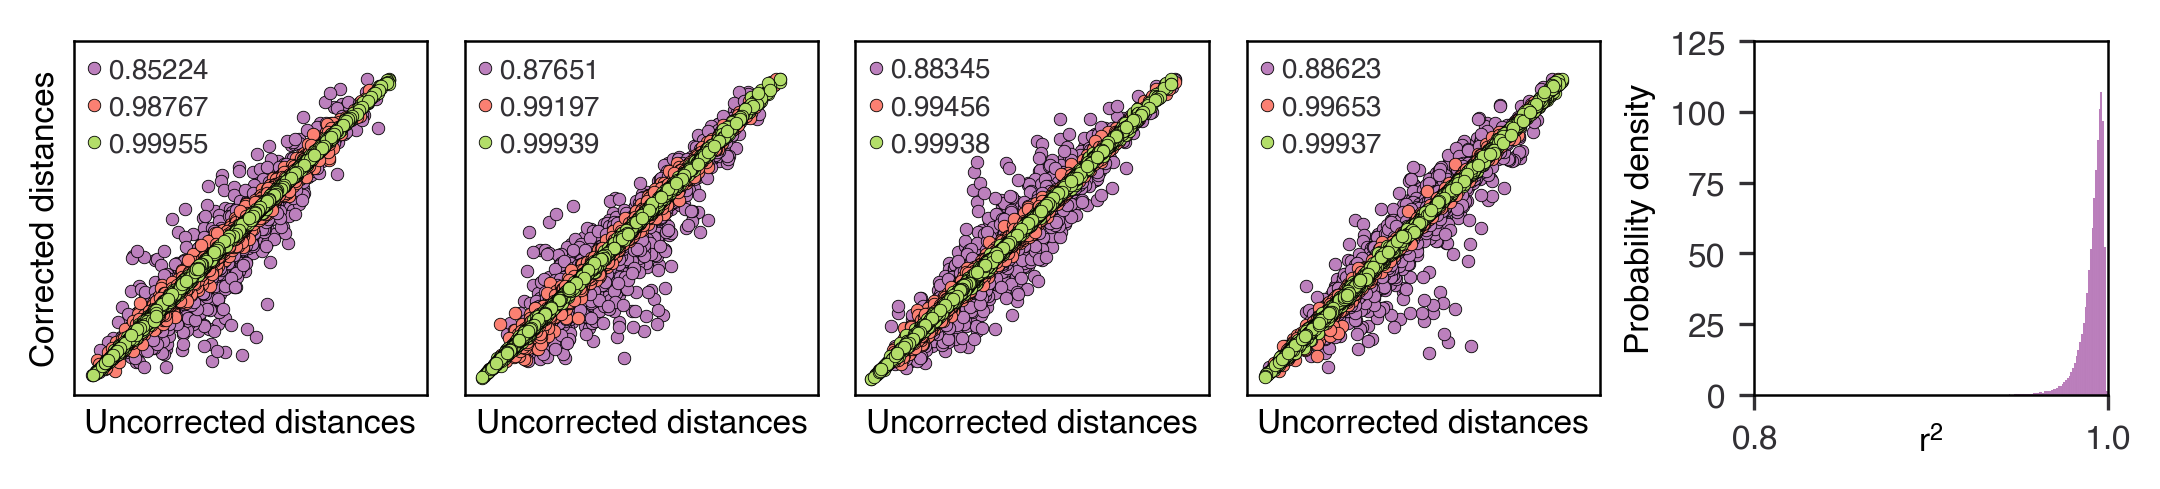

In [17]:
fig,axes = plt.subplots(ncols=5,nrows=1,figsize=(7.08661,1.67),layout='constrained')
for k,i in enumerate(range(-1,-5,-1)):
    qi = quintile_idxs[i]
    compare_dists_scatter(
        [sorted_r2_indices[i],sorted_r2_indices[qi],sorted_r2_indices[k]],
        [sorted_r2[i],sorted_r2[qi],sorted_r2[k]],
        fig=fig,
        ax=axes[k],
        norm=True
    )

    axes[k].set_ylabel('Corrected distances' if k==0 else '')

ax = axes[-1]
bins = torch.arange(.8,1.0005,.001)
ax.hist(sorted_r2,density=True,bins=bins,linewidth=.001);
ax.set_xlim([.8,1.])
ax.set_xticks([.8,1.])
ax.set_ylabel('Probability density')
ax.set_xlabel('$\\mathdefault{r^2}$',labelpad=-7)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

fig.savefig(save_folder+'2d_plots.pdf')